In [1]:
!pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 17.0 MB/s e

In [2]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os
import gradio as gr

torch.manual_seed(1)
#if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [3]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

(…)fusion-v1-4/resolve/main/vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

(…)it-large-patch14/resolve/main/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

(…)it-large-patch14/resolve/main/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)h14/resolve/main/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

(…)tch14/resolve/main/tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

(…)t-large-patch14/resolve/main/config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

(…)usion-v1-4/resolve/main/unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [4]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [5]:
# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32)

In [6]:
def getStyleEmbeds(filename, stylename):
  return torch.load(filename)[stylename]

In [7]:
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding

position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)

def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output


In [8]:
#Generating an image with these modified embeddings
from PIL import Image
import torchvision.transforms as transforms

def generate_with_embs(text_embeddings, seed, text_input, scale, steps, loss_fn = None, custom_loss_scale = 200):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = steps            # Number of denoising steps
    guidance_scale = scale               # Scale for classifier-free guidance
    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        if loss_fn is not None:
            if i%2 == 0:
                latents, custom_loss = guidance(latents, scheduler, noise_pred, t, sigma, loss_fn, custom_loss_scale)
                #print(i, 'loss:', custom_loss.item())

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

def guidance(latents, scheduler, noise_pred, t, sigma, custom_loss_fn, custom_loss_scale):
    #### ADDITIONAL GUIDANCE ###
    # Requires grad on the latents
    latents = latents.detach().requires_grad_()

    # Get the predicted x0:
    latents_x0 = latents - sigma * noise_pred
    #print(f"latents: {latents.shape}, noise_pred:{noise_pred.shape}")
    #latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

    # Decode to image space
    denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

    # Calculate loss
    loss = custom_loss_fn(denoised_images) * custom_loss_scale

    # Get gradient
    cond_grad = torch.autograd.grad(loss, latents, allow_unused=False)[0]

    # Modify the latents based on this gradient
    latents = latents.detach() - cond_grad * sigma**2
    return latents, loss

def my_loss(gen_image):
    image = Image.open('sample.jpg')

    # Define a transform to convert PIL
    # image to a Torch tensor
    transform = transforms.Compose([
        transforms.PILToTensor(),
        transforms.Resize((512,512)),
    ])

    # transform = transforms.PILToTensor()
    # Convert the PIL image to Torch tensor
    img_tensor = transform(image)
    img_tensor = img_tensor/255

    error = torch.abs(gen_image - img_tensor.to(torch_device)).sum()
    return error

from torchvision.transforms import v2
def random_permutation_loss(gen_image):
    transform = v2.RandomChannelPermutation()
    transform_img = transform(gen_image)
    loss = torch.abs(gen_image - transform_img).sum()
    #loss = torch.nn.functional.mse_loss(gen_image[:,0], gen_image[:,2]) + torch.nn.functional.mse_loss(gen_image[:,2], gen_image[:,1]) + torch.nn.functional.mse_loss(gen_image[:,0], gen_image[:,1])

    return loss

def random_elastic_loss(gen_image):
    transform = v2.ElasticTransform(alpha=250.0)
    transform_img = transform(gen_image)
    loss = torch.abs(gen_image - transform_img).sum()
    #loss = torch.nn.functional.mse_loss(gen_image[:,0], gen_image[:,2]) + torch.nn.functional.mse_loss(gen_image[:,2], gen_image[:,1]) + torch.nn.functional.mse_loss(gen_image[:,0], gen_image[:,1])
    return loss

def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(images[:,2] - 0.9).mean() # [:,2] -> all images in batch, only the blue channel
    return error



In [19]:
def produceImage(prompt, seed, styleEmbeds, scale, steps, loss_fn = None, custom_loss_scale = 200):
  eos_pos = len(prompt.split())+1
  # Tokenize
  text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
  input_ids = text_input.input_ids.to(torch_device)

  # Get token embeddings
  token_embeddings = token_emb_layer(input_ids)

  # The new embedding - our special birb word
  replacement_token_embedding = styleEmbeds.to(torch_device)

  # Insert this into the token embeddings
  token_embeddings[-1, eos_pos, :] = replacement_token_embedding

  # Combine with pos embs
  input_embeddings = token_embeddings + position_embeddings

  #  Feed through to get final output embs
  modified_output_embeddings = get_output_embeds(input_embeddings)

  # And generate an image with this:
  return generate_with_embs(modified_output_embeddings, seed, text_input, scale, steps, loss_fn, custom_loss_scale)

In [20]:
birb_style = '<birb-style>'
birb_seed = 32
birb_file = 'learned_embeds_birb.bin'
birb_embeds = getStyleEmbeds(birb_file, birb_style)

hewlett_style = '<dr-strange>'
hewlett_seed = 64
hewlett_file = 'learned_embeds_drstrange.bin'
hewlett_embeds = getStyleEmbeds(hewlett_file, hewlett_style)

midjourney_style = '<madhubani-art>'
midjourney_seed = 128
midjourney_file = 'learned_embeds_madhubani.bin'
midjourney_embeds = getStyleEmbeds(midjourney_file, midjourney_style)

portrait_style = '<portrait-style-dishonored>'
portrait_seed = 256
portrait_file = 'learned_embeds_portrait.bin'
portrait_embeds = getStyleEmbeds(portrait_file, portrait_style)

xyz_style = '<xyz>'
xyz_seed = 512
xyz_file = 'learned_embeds_xyz.bin'
xyz_embeds = getStyleEmbeds(xyz_file, xyz_style)


In [21]:
def predict(input_query, seed, scale, steps):
    predicted_images = []
    predicted_images.append(produceImage(input_query, seed, birb_embeds, scale, steps))
    predicted_images.append(produceImage(input_query, seed + 5, hewlett_embeds, scale, steps))
    predicted_images.append(produceImage(input_query, seed + 10, midjourney_embeds, scale, steps))
    predicted_images.append(produceImage(input_query, seed + 15, portrait_embeds, scale, steps))
    predicted_images.append(produceImage(input_query, seed + 20, xyz_embeds, scale, steps))

    predicted_images.append(produceImage(input_query, seed, birb_embeds, scale, steps, loss_fn = random_permutation_loss, custom_loss_scale = 1/50000))
    predicted_images.append(produceImage(input_query, seed + 5, hewlett_embeds, scale, steps, loss_fn = random_permutation_loss, custom_loss_scale = 1/50000))
    predicted_images.append(produceImage(input_query, seed + 10, midjourney_embeds, scale, steps, loss_fn = random_permutation_loss, custom_loss_scale = 1/50000))
    predicted_images.append(produceImage(input_query, seed + 15, portrait_embeds, scale, steps, loss_fn = random_permutation_loss, custom_loss_scale = 1/50000))
    predicted_images.append(produceImage(input_query, seed + 20, xyz_embeds, scale, steps, loss_fn = random_permutation_loss, custom_loss_scale = 1/50000))
    return predicted_images

def inference(input_query, seed, scale, steps):
    if input_query is None:
        raise gr.Error("Please send a query string")
    seed = int(seed)
    scale = float(scale)
    steps = int(steps)
    predicted_images = predict(input_query, seed, scale, steps)
    return predicted_images

demo = gr.Interface(
    inference,
    inputs = [
        gr.Textbox(label='Input a query prompt to produce relevant image'),
        gr.Slider(10, 100, step = 10, value=50, label="Seed Value", info="Choose between 1 and 100", container=True),
        gr.Slider(1, 10, step = 0.5, value=7.5, label="Guidance Scale", info="Choose between 0 and 1", container=True),
        gr.Slider(30, 100, step = 10, value=30, label="Number of Inference steps", info="Choose between 30 and 100", container=True),
    ],
    outputs = [
              gr.Gallery(label='Output Images', show_label=True, preview=True),])

demo.queue()
demo.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://553e9ede596163f067.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


<ipython-input-8-a48f4ad0b524>:26: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://553e9ede596163f067.gradio.live


In [29]:
def show_images(images_list):
    # Let's visualize the four channels of this latent representation:
    fig, axs = plt.subplots(1, len(images_list), figsize=(16, 4))
    for c in range(len(images_list)):
        axs[c].imshow(images_list[c])
    plt.show()

In [23]:
imgs = predict("a puppy playing football", 50, 7.5, 30)

<ipython-input-8-a48f4ad0b524>:26: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

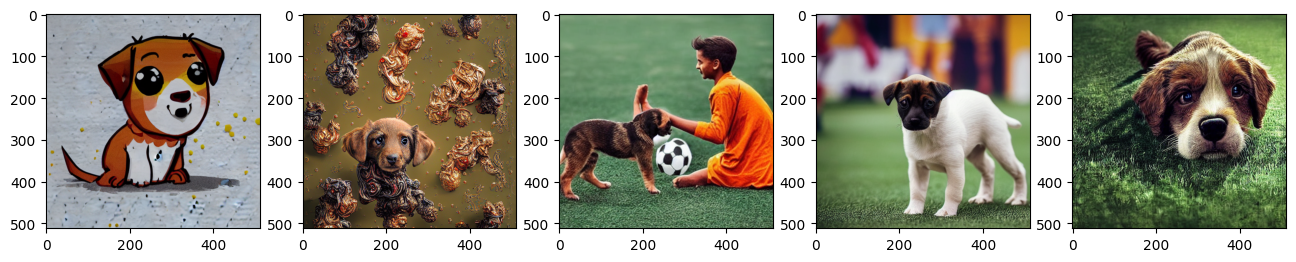

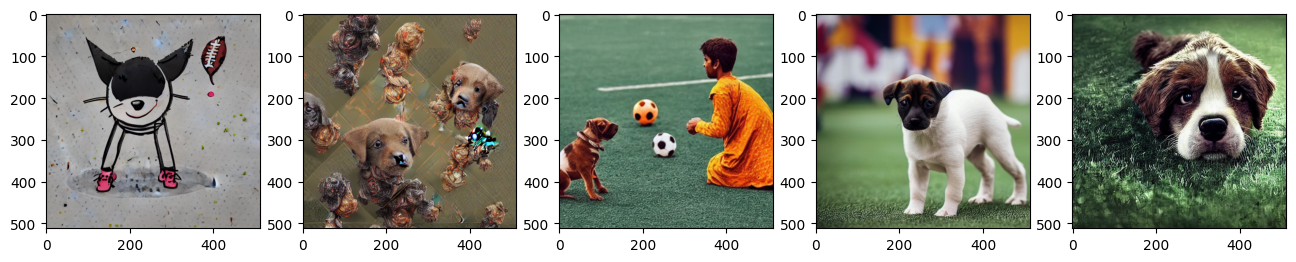

In [30]:
show_images(imgs[0:5])
show_images(imgs[5:])